# Predicting Heart Disease

The World Health Organization (WHO) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

In this project I am working with anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

heart_df = pd.read_csv('data\heart_disease_prediction.csv')
# first five rows
print(heart_df.head())
print('---')
# number of rows and columns
print('shape of the dataset:',heart_df.shape)
print('---')
# number of nulls
print(heart_df.isna().sum())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
---
shape of the dataset: (918, 12)
---
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
Exercis

In [2]:
# number of categorical and numerical columns
print(heart_df.dtypes.value_counts())
print('---')
# summary stats
print(heart_df.describe())

int64      6
object     5
float64    1
dtype: int64
---
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


In the dataset there is 12 columns. The target column `HeartDisease` and 11 other feature columns. There are 918 observations (rows) in the dataset and there are no nulls.   
The target column is in integer format, so will not require transformation. However there are five categorical columns in string format that may require one-hot encoding.  
The column `Cholesterol` has a max value of `603` which stands out as it is more than 3 times larger than the  mean of `198` also it has a min value of `0`. Similarly the min value of `RestingBP` is `0` which seems like an error as a blood pressure of 0 is not possible.

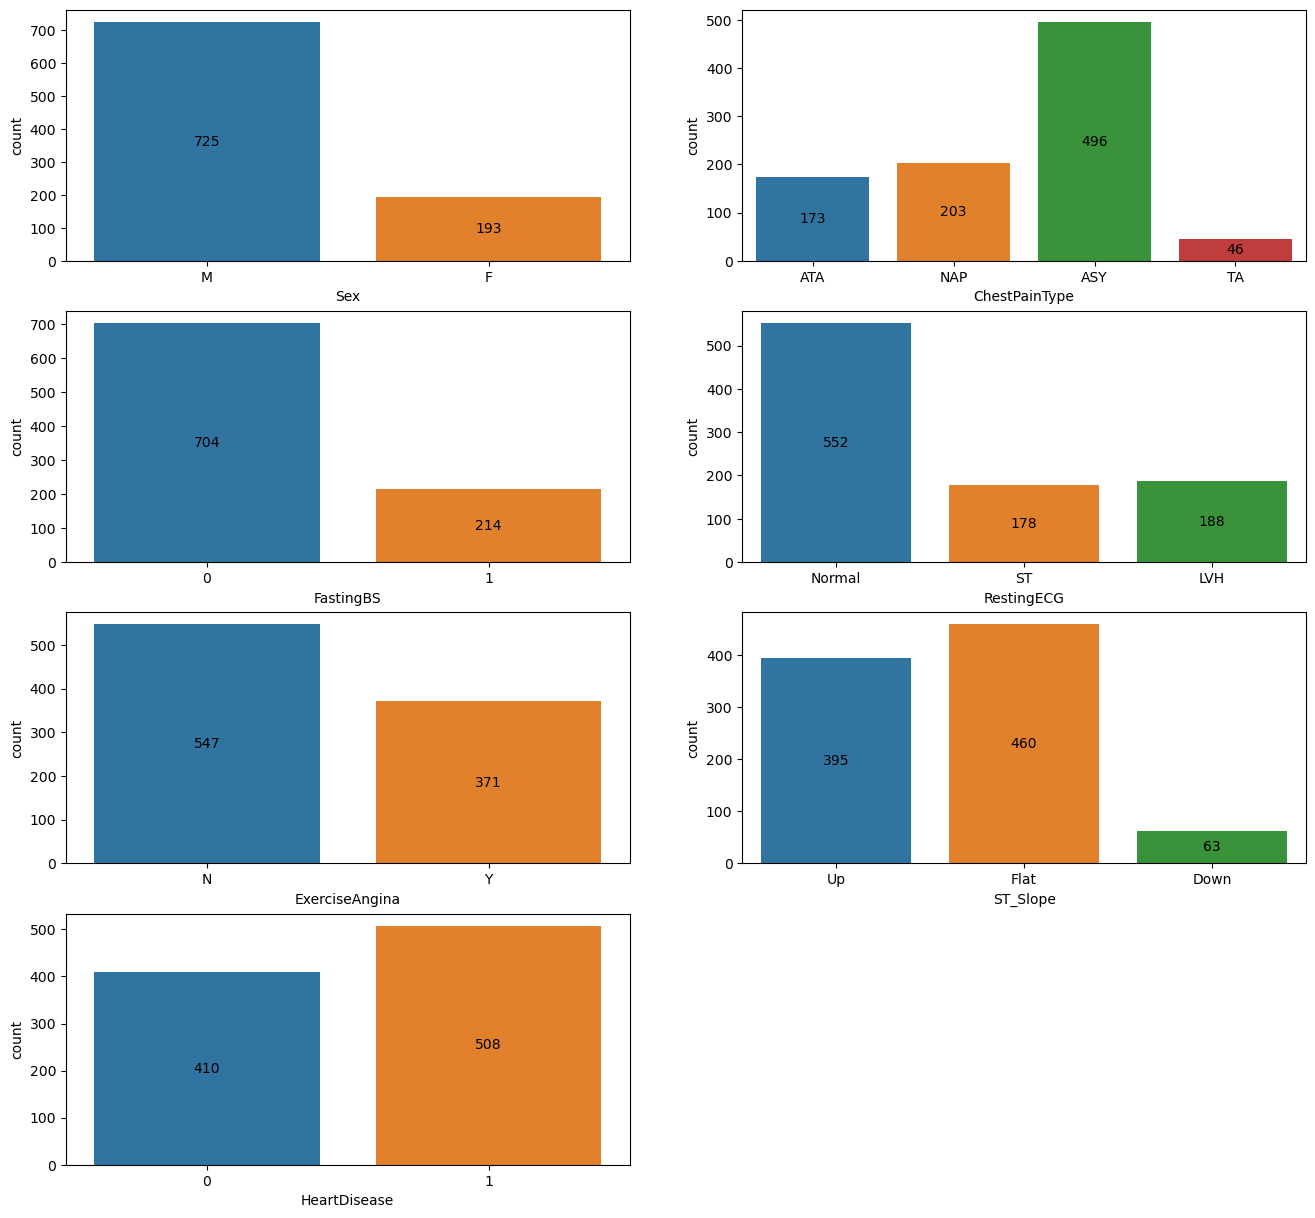

In [3]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=heart_df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

From these plots I can see that the typical observation:
- Did not have have fasting blood sugar
- Did not have exercise induced angina
- Had a normal resting ECG
- Had no chest pain
- Was Male

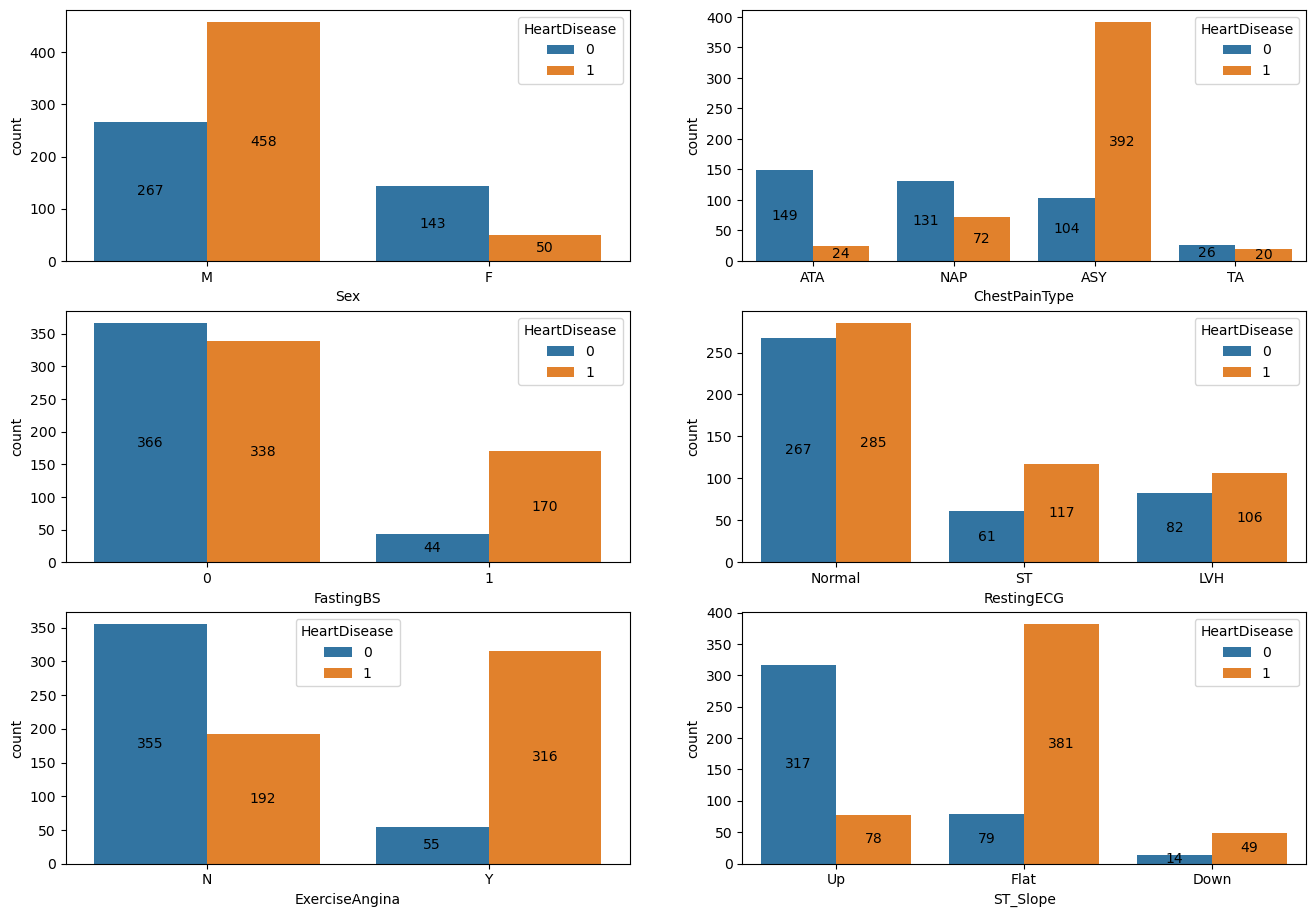

In [4]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=heart_df[col], hue=heart_df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

From the above plots I can see:
- Males are more likely to have heart disease than Females
- Those with heart disease are most likely to have asymtopmatic chest pain
- Those with heart disease are most likely to have exerciuse angina
- Those with heart disease are most likely to have a flat ST slope
- Those with heart disease are most likely to have a high resting blood sugar

### Data Cleaning

In [5]:
# find number of rows where resting bp and cholestorol is 0
print('Rows with 0 resting BP:',heart_df[heart_df['RestingBP'] == 0].shape[0])
print('Rows with 0 Cholesterol:',heart_df[heart_df['Cholesterol'] == 0].shape[0])

Rows with 0 resting BP: 1
Rows with 0 Cholesterol: 172


`RestingBP` has only one row with `0`, so it'll be ok to remove that row form the dataset. However there are 172 rows with `Cholesterol` value of `0`, so instead I'll replace these with the median value and the corresponding `HeartDisease`.

In [6]:
df_clean = heart_df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

cholesterol_nohd_meadian = df_clean.loc[df_clean["HeartDisease"]==0, "Cholesterol"].median()
cholesterol_hd_meadian = df_clean.loc[df_clean["HeartDisease"]==1, "Cholesterol"].median()

df_clean.loc[df_clean["HeartDisease"]==0, "Cholesterol"] = df_clean.loc[df_clean["HeartDisease"]==0, "Cholesterol"].replace(to_replace = 0, value = cholesterol_nohd_meadian)
df_clean.loc[df_clean["HeartDisease"]==1, "Cholesterol"] = df_clean.loc[df_clean["HeartDisease"]==1, "Cholesterol"].replace(to_replace = 0, value = cholesterol_hd_meadian)

In [7]:
df_clean[["RestingBP","Cholesterol"]].describe()

,RestingBP,Cholesterol
count,917.000000,917.000000
mean,132.540894,239.700109
std,17.999749,54.352727
min,80.000000,85.000000
25%,120.000000,214.000000
50%,130.000000,225.000000
75%,140.000000,267.000000
max,200.000000,603.000000


The min values for `RestingBP` and `Cholesterol` are now `80` and `85`, which seems much more appropriate when reading the associated documentation.

### Feature Selection

In [8]:
# one-hot encode the categorical feature columns
df_clean = pd.get_dummies(data=df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


<Axes: >

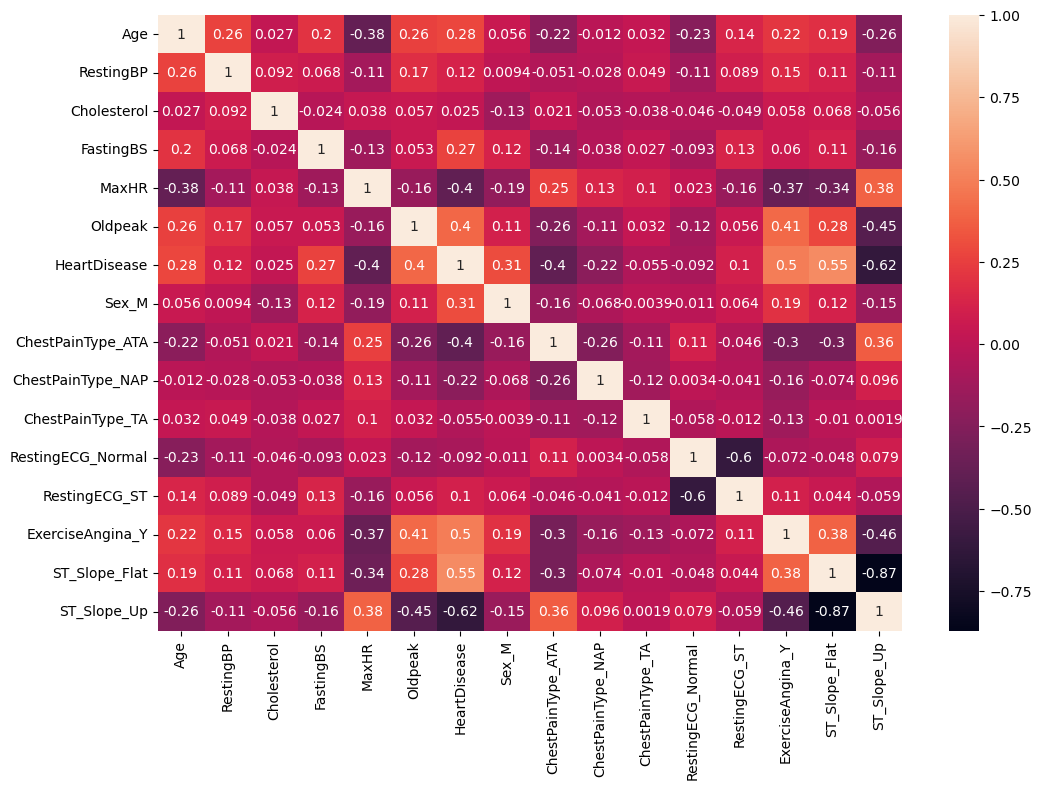

In [9]:
# calculate the Pearsons coeeficient
correlations = df_clean.corr()
# plot the correlations on a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True)

<Axes: >

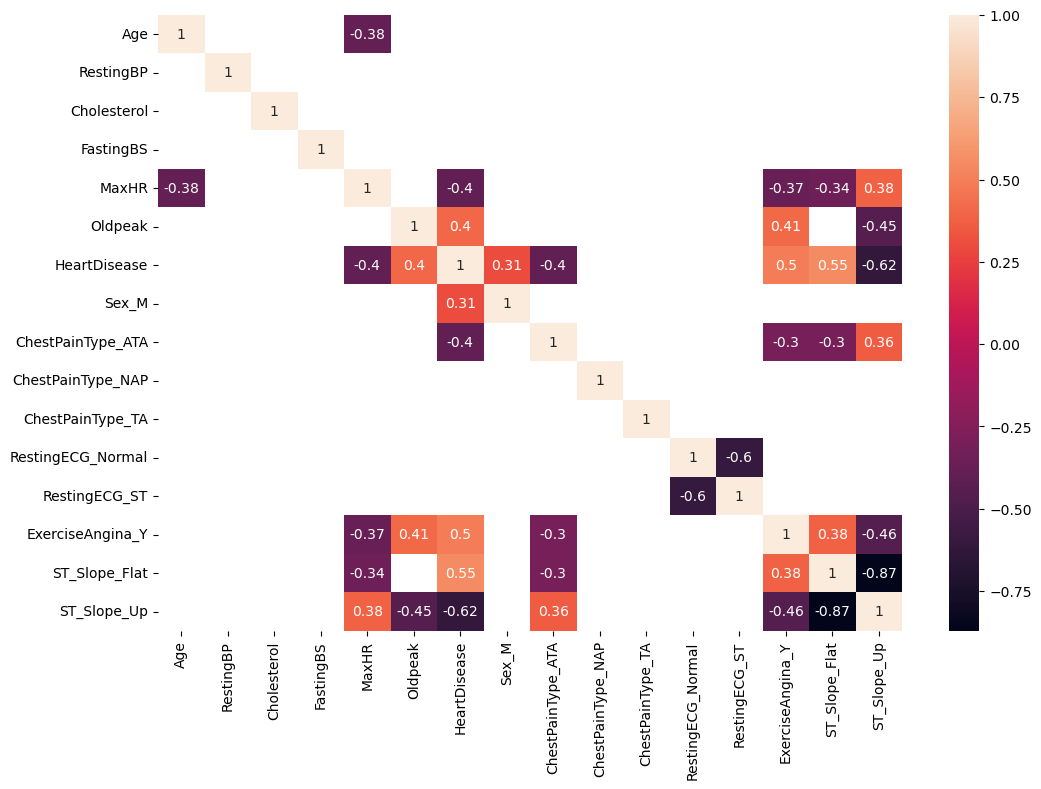

In [10]:
# filter the heatmap to show only strong correlations
plt.figure(figsize=(12,8))
sns.heatmap(correlations[abs(correlations) > 0.3], annot=True)

From the heatmap I can see the following features have the stronest correlation with `HeartDisease`:
- `ST_Slope_Up`
- `ST_Slope_Flat`
- `ExcerciseAngina_Y`
- `ChestPainType_TA`
- `MaxHR`
- `OldPeak`
- `Sex_M`

### Training a Classifier Model

In [11]:
# split the dataset into train and validation
X = df_clean.drop(columns='HeartDisease')
y = df_clean['HeartDisease']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=120)

In [12]:
features = ["ST_Slope_Up",
    "ST_Slope_Flat",
    "ExerciseAngina_Y",
    "ChestPainType_TA",
    "MaxHR",
    "Oldpeak",
    "Sex_M"]

for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 79.89%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 76.09%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 54.89%
The k-NN classifier trained on ChestPainType_TA and with k = 3 has an accuracy of 55.43%
The k-NN classifier trained on MaxHR and with k = 3 has an accuracy of 68.48%
The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 57.07%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 69.02%


With accuracy scores all above 70%, the features `ST_Slope_Up`, `ST_Slope_Flat` and `ExerciseAngina_Y` gave the best results.  
With accuracy scores below 55%, the features `Oldpeak` and `ChestPainType_TA` underperformed.

### Refining the Classifier Model

In [13]:
# Scaling the columns
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [14]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
score = knn.score(X_val_scaled, y_val)
print(f'model accuracy: {score*100:.2f}%')

model accuracy: 84.24%


The model accuracy has increased to `84%` by using all features with a Person's coeeficient of 0.3 or more and scaling the features before training.

### Hyperparameter Optimisation

I will now attempt to improve the accuracy of the model by tuning the hyperparameters. I will achieve this by using `GridSearchCV`.  
The hyperameters I will experiment with are:
- `n_neighbors`
- `weights`
- `metric`

In [15]:
# create a dictionary with different values for the hyperparameters
grid_params = {"n_neighbors": list(range(1,21)),
               "weights": ["uniform", "distance"],
               "metric": ["minkowski", "manhattan"]}

# Use GridSearch to train the model and find the best params
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring="accuracy")
knn_grid.fit(X_train_scaled, y_train)

print("best score:",knn_grid.best_score_)
print("parameters for best score:",knn_grid.best_params_)

best score: 0.8403783431180691
parameters for best score: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


The best accuracy score produced by the GridSearch was `84.03%` using `metric='mahattan'` , `n_neighbors=15` and `weights='uniform'`.  
The accuracy score is slightly less than the previous accuracy score, however this is likely to GridSearch using cross-validation for the accuracy score.

### Model Evaluation on Test Set

In [16]:
# make predictions on the test set using the best model form GridSearch
predictions = knn_grid.best_estimator_.predict(X_val_scaled)
# calculate accuracy of the predictions
accuracy = accuracy_score(y_val, predictions)
print(f'On the test set the model had an accuracy of {accuracy*100:,.2f}%')

On the test set the model had an accuracy of 85.87%


The accuracy of `85.87%` is good, meaning the model accurately predicted if someone had heart disease nearly 86% of the time.  
The accuracy on the test set is higher than the training set raises some flags.

One explanation that could explain is to look at how the data is distributed.

In [17]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts(normalize=True))

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts(normalize=True))

print("\nDistribution of patients by their sex in the test dataset")
print(X_val.Sex_M.value_counts(normalize=True))

Distribution of patients by their sex in the entire dataset
1    0.789531
0    0.210469
Name: Sex_M, dtype: float64

Distribution of patients by their sex in the training dataset
1    0.791269
0    0.208731
Name: Sex_M, dtype: float64

Distribution of patients by their sex in the test dataset
1    0.782609
0    0.217391
Name: Sex_M, dtype: float64


The low number of Females may explain the increased accuracy of the test set

### Summary

I trained a `KNeighborsClassifier` model using the features `ST_Slope, ExerciseAngina_Y, ChestPainType, MaxHR, Oldpeak, Sex` to predict the target `HeartDisease`.  
    The features were one-hot encoded using `get_dummies` and scaled using `MinMax